# Tuning Neural Networks with Regularization - Lab 

## Introduction

In this lab, you'll use a train-test partition as well as a validation set to get better insights about how to tune neural networks using regularization techniques. You'll start by repeating the process from the last section: importing the data and performing preprocessing including one-hot encoding. From there, you'll define and compile the model like before. 

## Objectives

You will be able to:

- Apply early stopping criteria with a neural network 
- Apply L1, L2, and dropout regularization on a neural network  
- Examine the effects of training with more data on a neural network  


## Load the Data

Run the following cell to import some of the libraries and classes you'll need in this lab. 

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
#from keras.utils.np_utils import to_categorical
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.text import Tokenizer

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

The data is stored in the file `'Bank_complaints.csv'`. Load and preview the dataset.

In [3]:
# Load and preview the dataset
df = pd.read_csv('Bank_complaints.csv')
df.head()

,Product,Consumer complaint narrative
0,Student loan,In XX/XX/XXXX I filled out the Fedlaon applica...
1,Student loan,I am being contacted by a debt collector for p...
2,Student loan,I cosigned XXXX student loans at SallieMae for...
3,Student loan,Navient has sytematically and illegally failed...
4,Student loan,My wife became eligible for XXXX Loan Forgiven...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Product                       60000 non-null  object
 1   Consumer complaint narrative  60000 non-null  object
dtypes: object(2)
memory usage: 937.6+ KB


## Preprocessing Overview

Before you begin to practice some of your new tools such as regularization and optimization, let's practice munging some data as you did in the previous section with bank complaints. Recall some techniques:

* Sampling in order to reduce training time (investigate model accuracy vs data size later on)
* Train - test split
* One-hot encoding your complaint text
* Transforming your category labels 

## Preprocessing: Generate a Random Sample

Since you have quite a bit of data and training neural networks takes a substantial amount of time and resources, downsample in order to test your initial pipeline. Going forward, these can be interesting areas of investigation: how does your model's performance change as you increase (or decrease) the size of your dataset?  

- Generate a random sample of 10,000 observations using seed 123 for consistency of results. 
- Split this sample into `X` and `y` 

In [4]:
# Downsample the data
df_sample = df.sample(10000, random_state=123)

# Split the data into X and y
y = df_sample['Product']
X = df_sample['Consumer complaint narrative']

## Train-test split

- Split the data into training and test sets 
- Assign 1500 obervations to the test set and use 42 as the seed 

In [6]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1500, random_state=42)

## Validation set 

As mentioned in the previous lesson, it is good practice to set aside a validation set, which is then used during hyperparameter tuning. Afterwards, when you have decided upon a final model, the test set can then be used to determine an unbiased perforance of the model. 

Run the cell below to further divide the training data into training and validation sets. 

In [7]:
# Split the data into training and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=1000, random_state=42)

## Preprocessing: One-hot Encoding the Complaints

As before, you need to do some preprocessing before building a neural network model. 

- Keep the 2,000 most common words and use one-hot encoding to reformat the complaints into a matrix of vectors 
- Transform the training, validate, and test sets 

In [8]:
# Use one-hot encoding to reformat the complaints into a matrix of vectors 
# Only keep the 2000 most common words 

tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(X_train_final)

X_train_tokens = tokenizer.texts_to_matrix(X_train_final, mode='binary')
X_val_tokens = tokenizer.texts_to_matrix(X_val, mode='binary')
X_test_tokens = tokenizer.texts_to_matrix(X_test, mode='binary')

## Preprocessing: Encoding the Products

Similarly, now transform the descriptive product labels to integers labels. After transforming them to integer labels, retransform them into a matrix of binary flags, one for each of the various product labels.  
  
> **Note**: This is similar to your previous work with dummy variables. Each of the various product categories will be its own column, and each observation will be a row. In turn, each of these observation rows will have a 1 in the column associated with it's label, and all other entries for the row will be zero. 

Transform the training, validate, and test sets. 

In [9]:
# Transform the product labels to numerical values
lb = LabelBinarizer()
lb.fit(y_train_final)

y_train_lb = to_categorical(lb.transform(y_train_final))[:, :, 1]
y_val_lb = to_categorical(lb.transform(y_val))[:, :, 1]
y_test_lb = to_categorical(lb.transform(y_test))[:, :, 1]

## A Baseline Model 

Rebuild a fully connected (Dense) layer network:  
- Use 2 hidden layers with 50 units in the first and 25 in the second layer, both with `'relu'` activation functions (since you are dealing with a multiclass problem, classifying the complaints into 7 classes) 
- Use a `'softmax'` activation function for the output layer  

In [10]:
# Build a baseline neural network model using Keras
random.seed(123)
from keras import models
from keras import layers
baseline_model = models.Sequential()
baseline_model.add(layers.Dense(50, activation='relu', input_shape=(2000,)))
baseline_model.add(layers.Dense(25, activation='relu'))
baseline_model.add(layers.Dense(7, activation='softmax'))

### Compile the Model

Compile this model with: 

- a stochastic gradient descent optimizer 
- `'categorical_crossentropy'` as the loss function 
- a focus on `'accuracy'` 

In [11]:
# Compile the model
baseline_model.compile(optimizer='SGD', 
                       loss='categorical_crossentropy', 
                       metrics=['acc'])

### Train the Model

- Train the model for 150 epochs in mini-batches of 256 samples 
- Include the `validation_data` argument to ensure you keep track of the validation loss  

In [12]:
# Train the model
baseline_model_val = baseline_model.fit(X_train_tokens, 
                                        y_train_lb, 
                                        epochs=150, 
                                        batch_size=256, 
                                        validation_data=(X_val_tokens, y_val_lb))

Epoch 1/150
30/30 [==============================] - 0s 4ms/step - loss: 1.9593 - acc: 0.1419 - val_loss: 1.9606 - val_acc: 0.1430
Epoch 2/150
30/30 [==============================] - 0s 1ms/step - loss: 1.9430 - acc: 0.1717 - val_loss: 1.9475 - val_acc: 0.1490
Epoch 3/150
30/30 [==============================] - 0s 3ms/step - loss: 1.9296 - acc: 0.1935 - val_loss: 1.9356 - val_acc: 0.1750
Epoch 4/150
30/30 [==============================] - 0s 1ms/step - loss: 1.9157 - acc: 0.2203 - val_loss: 1.9219 - val_acc: 0.1960
Epoch 5/150
30/30 [==============================] - 0s 1ms/step - loss: 1.8994 - acc: 0.2391 - val_loss: 1.9054 - val_acc: 0.2160
Epoch 6/150
30/30 [==============================] - 0s 1ms/step - loss: 1.8800 - acc: 0.2619 - val_loss: 1.8859 - val_acc: 0.2310
Epoch 7/150
30/30 [==============================] - 0s 1ms/step - loss: 1.8571 - acc: 0.2849 - val_loss: 1.8618 - val_acc: 0.2560
Epoch 8/150
30/30 [==============================] - 0s 1ms/step - loss: 1.8299 - a

### Model Performance

The attribute `.history` (stored as a dictionary) contains four entries now: one per metric that was being monitored during training and validation. Print the keys of this dictionary for confirmation: 

In [13]:
# Access the history attribute and store the dictionary
baseline_model_val_dict = baseline_model_val.history

# Print the keys
baseline_model_val_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

Evaluate this model on the training data: 

In [14]:
results_train = baseline_model.evaluate(X_train_tokens, y_train_lb)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

235/235 [==============================] - 0s 378us/step - loss: 0.2946 - acc: 0.9116
----------
Training Loss: 0.295 
Training Accuracy: 0.912


Evaluate this model on the test data: 

In [15]:
results_test = baseline_model.evaluate(X_test_tokens, y_test_lb)
print('----------')
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')

47/47 [==============================] - 0s 483us/step - loss: 0.6159 - acc: 0.7827
----------
Test Loss: 0.616 
Test Accuracy: 0.783


### Plot the Results 

Plot the loss versus the number of epochs. Be sure to include the training and the validation loss in the same plot. 

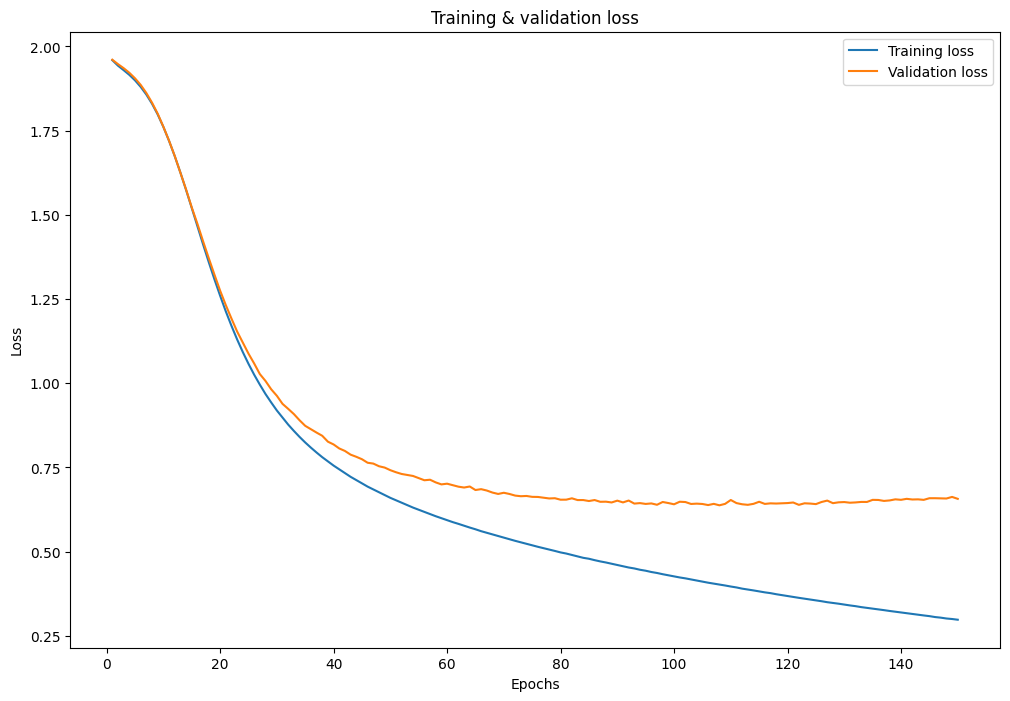

In [16]:
# Loss vs number of epochs with train and validation sets
fig, ax = plt.subplots(figsize=(12, 8))

loss_values = baseline_model_val_dict['loss']
val_loss_values = baseline_model_val_dict['val_loss']

epochs = range(1, len(loss_values) + 1)
ax.plot(epochs, loss_values, label='Training loss')
ax.plot(epochs, val_loss_values, label='Validation loss')

ax.set_title('Training & validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();

Create a second plot comparing training and validation accuracy to the number of epochs. 

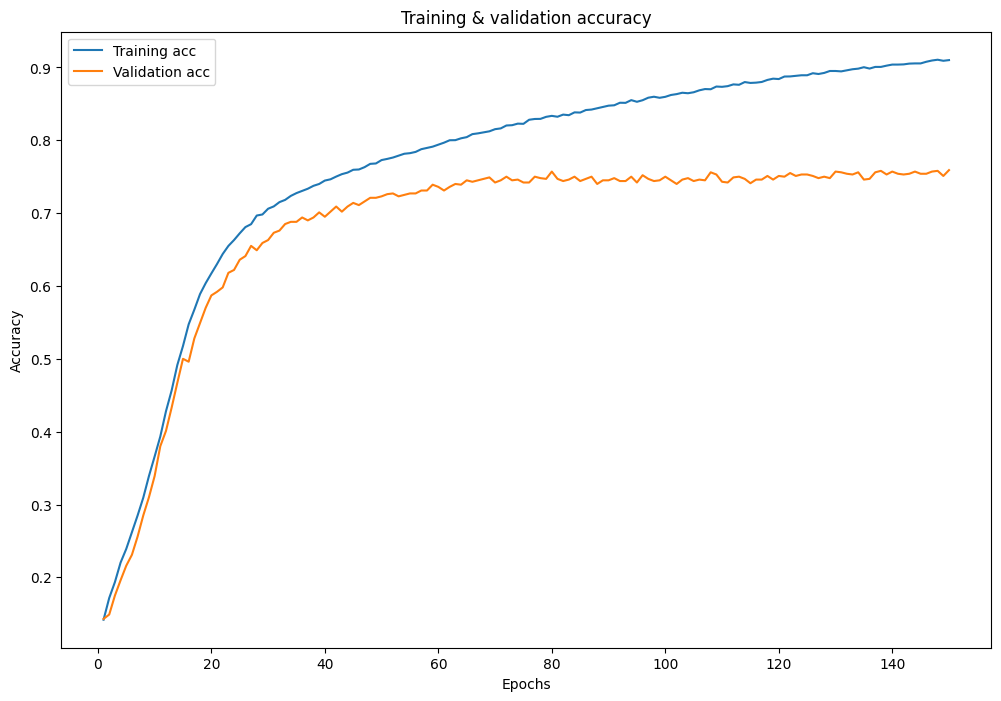

In [17]:
# Accuracy vs number of epochs with train and validation sets
fig, ax = plt.subplots(figsize=(12, 8))

acc_values = baseline_model_val_dict['acc'] 
val_acc_values = baseline_model_val_dict['val_acc']

ax.plot(epochs, acc_values, label='Training acc')
ax.plot(epochs, val_acc_values, label='Validation acc')
ax.set_title('Training & validation accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend();

Did you notice an interesting pattern here? Although the training accuracy keeps increasing when going through more epochs, and the training loss keeps decreasing, the validation accuracy and loss don't necessarily do the same. After a certain point, validation accuracy keeps swinging, which means that you're probably **overfitting** the model to the training data when you train for many epochs past a certain dropoff point. Let's tackle this now. You will now specify an early stopping point when training your model. 


## Early Stopping

Overfitting neural networks is something you **_want_** to avoid at all costs. However, it's not possible to know in advance how many *epochs* you need to train your model on, and running the model multiple times with varying number of *epochs* maybe helpful, but is a time-consuming process. 

We've defined a model with the same architecture as above. This time specify an early stopping point when training the model. 

In [18]:
random.seed(123)
model_2 = models.Sequential()
model_2.add(layers.Dense(50, activation='relu', input_shape=(2000,)))
model_2.add(layers.Dense(25, activation='relu'))
model_2.add(layers.Dense(7, activation='softmax'))

model_2.compile(optimizer='SGD', 
                loss='categorical_crossentropy', 
                metrics=['acc'])

- Import `EarlyStopping` and `ModelCheckpoint` from `keras.callbacks` 
- Define a list, `early_stopping`: 
  - Monitor `'val_loss'` and continue training for 10 epochs before stopping 
  - Save the best model while monitoring `'val_loss'` 
 
> If you need help, consult [documentation](https://keras.io/callbacks/).   

In [19]:
# Import EarlyStopping and ModelCheckpoint
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the callbacks
early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

Train `model_2`. Make sure you set the `callbacks` argument to `early_stopping`. 

In [20]:
model_2_val = model_2.fit(X_train_tokens, 
                          y_train_lb, 
                          epochs=150, 
                          callbacks=early_stopping, 
                          batch_size=256, 
                          validation_data=(X_val_tokens, y_val_lb))

Epoch 1/150
30/30 [==============================] - 0s 4ms/step - loss: 1.9592 - acc: 0.1436 - val_loss: 1.9603 - val_acc: 0.1450
Epoch 2/150
30/30 [==============================] - 0s 2ms/step - loss: 1.9428 - acc: 0.1677 - val_loss: 1.9474 - val_acc: 0.1480
Epoch 3/150
30/30 [==============================] - 0s 2ms/step - loss: 1.9295 - acc: 0.1949 - val_loss: 1.9352 - val_acc: 0.1690
Epoch 4/150
30/30 [==============================] - 0s 2ms/step - loss: 1.9152 - acc: 0.2173 - val_loss: 1.9215 - val_acc: 0.1930
Epoch 5/150
30/30 [==============================] - 0s 2ms/step - loss: 1.8988 - acc: 0.2376 - val_loss: 1.9052 - val_acc: 0.2130
Epoch 6/150


/opt/anaconda3/envs/my_py_3_8_5_env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 [==============================] - 0s 2ms/step - loss: 1.8793 - acc: 0.2615 - val_loss: 1.8851 - val_acc: 0.2320
Epoch 7/150
30/30 [==============================] - 0s 2ms/step - loss: 1.8562 - acc: 0.2873 - val_loss: 1.8610 - val_acc: 0.2530
Epoch 8/150
30/30 [==============================] - 0s 1ms/step - loss: 1.8289 - acc: 0.3123 - val_loss: 1.8321 - val_acc: 0.2900
Epoch 9/150
30/30 [==============================] - 0s 1ms/step - loss: 1.7965 - acc: 0.3400 - val_loss: 1.7983 - val_acc: 0.3130
Epoch 10/150
30/30 [==============================] - 0s 2ms/step - loss: 1.7593 - acc: 0.3663 - val_loss: 1.7597 - val_acc: 0.3530
Epoch 11/150
30/30 [==============================] - 0s 2ms/step - loss: 1.7177 - acc: 0.3983 - val_loss: 1.7176 - val_acc: 0.3810
Epoch 12/150
30/30 [==============================] - 0s 2ms/step - loss: 1.6723 - acc: 0.4280 - val_loss: 1.6713 - val_acc: 0.4010
Epoch 13/150
30/30 [==============================] - 0s 2ms/step - loss: 1.6235 - acc: 0.45

Load the best (saved) model. 

In [21]:
# Load the best (saved) model
from keras.models import load_model
saved_model = load_model('best_model.h5')

Now, use this model to to calculate the training and test accuracy: 

In [22]:
results_train = saved_model.evaluate(X_train_tokens, y_train_lb)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_test = saved_model.evaluate(X_test_tokens, y_test_lb)
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')

235/235 [==============================] - 0s 399us/step - loss: 0.4018 - acc: 0.8741
Training Loss: 0.402 
Training Accuracy: 0.874
----------
47/47 [==============================] - 0s 405us/step - loss: 0.6064 - acc: 0.7833
Test Loss: 0.606 
Test Accuracy: 0.783


Nicely done! Did you notice that the model didn't train for all 150 epochs? You reduced your training time. 

Now, take a look at how regularization techniques can further improve your model performance. 

## L2 Regularization 

First, take a look at L2 regularization. Keras makes L2 regularization easy. Simply add the `kernel_regularizer=keras.regularizers.l2(lambda_coeff)` parameter to any model layer. The `lambda_coeff` parameter determines the strength of the regularization you wish to perform. 

- Use 2 hidden layers with 50 units in the first and 25 in the second layer, both with `'relu'` activation functions 
- Add L2 regularization to both the hidden layers with 0.005 as the `lambda_coeff` 

In [23]:
# Import regularizers
from keras import regularizers
random.seed(123)
L2_model = models.Sequential()

# Add the input and first hidden layer
L2_model.add(layers.Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.005), input_shape=(2000,)))

# Add another hidden layer
L2_model.add(layers.Dense(25, kernel_regularizer=regularizers.l2(0.005), activation='relu'))

# Add an output layer
L2_model.add(layers.Dense(7, activation='softmax'))

# Compile the model
L2_model.compile(optimizer='SGD', 
                 loss='categorical_crossentropy', 
                 metrics=['acc'])

# Train the model 
L2_model_val = L2_model.fit(X_train_tokens, 
                            y_train_lb, 
                            epochs=150, 
                            batch_size=256, 
                            validation_data=(X_val_tokens, y_val_lb))

Epoch 1/150
30/30 [==============================] - 0s 3ms/step - loss: 2.6150 - acc: 0.1423 - val_loss: 2.6143 - val_acc: 0.1400
Epoch 2/150
30/30 [==============================] - 0s 2ms/step - loss: 2.5946 - acc: 0.1672 - val_loss: 2.5973 - val_acc: 0.1470
Epoch 3/150
30/30 [==============================] - 0s 2ms/step - loss: 2.5774 - acc: 0.1935 - val_loss: 2.5811 - val_acc: 0.1730
Epoch 4/150
30/30 [==============================] - 0s 2ms/step - loss: 2.5595 - acc: 0.2172 - val_loss: 2.5638 - val_acc: 0.1960
Epoch 5/150
30/30 [==============================] - 0s 2ms/step - loss: 2.5399 - acc: 0.2388 - val_loss: 2.5444 - val_acc: 0.2150
Epoch 6/150
30/30 [==============================] - 0s 2ms/step - loss: 2.5175 - acc: 0.2615 - val_loss: 2.5217 - val_acc: 0.2280
Epoch 7/150
30/30 [==============================] - 0s 2ms/step - loss: 2.4920 - acc: 0.2839 - val_loss: 2.4953 - val_acc: 0.2500
Epoch 8/150
30/30 [==============================] - 0s 2ms/step - loss: 2.4623 - a

Now, look at the training as well as the validation accuracy for both the L2 and the baseline models. 

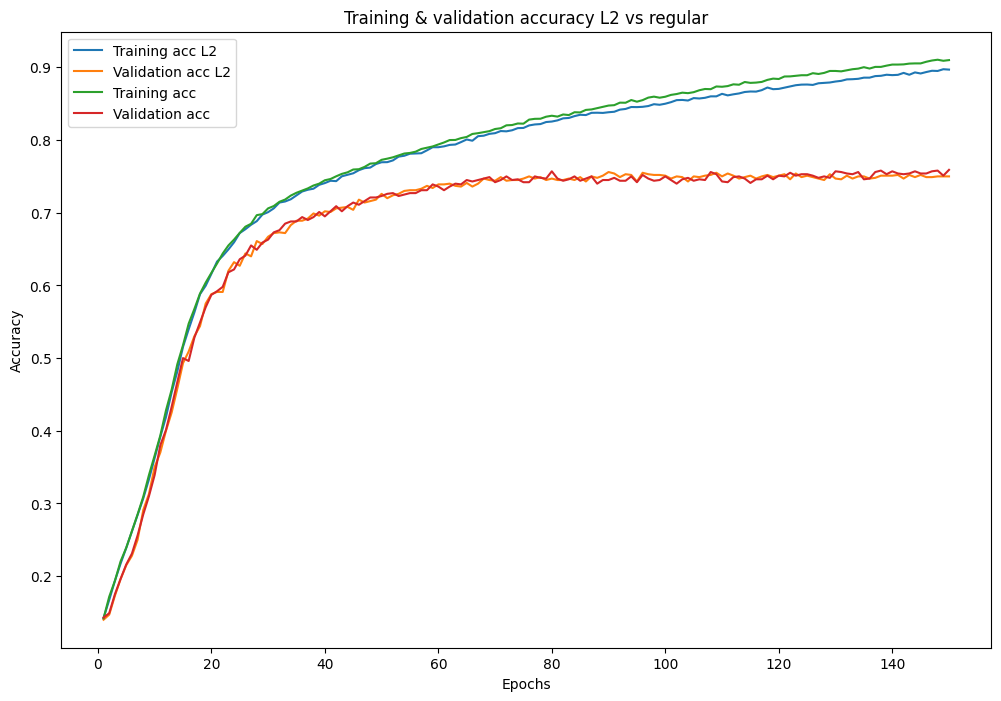

In [24]:
# L2 model details
L2_model_dict = L2_model_val.history
L2_acc_values = L2_model_dict['acc'] 
L2_val_acc_values = L2_model_dict['val_acc']

# Baseline model
baseline_model_acc = baseline_model_val_dict['acc'] 
baseline_model_val_acc = baseline_model_val_dict['val_acc']

# Plot the accuracy for these models
fig, ax = plt.subplots(figsize=(12, 8))
epochs = range(1, len(acc_values) + 1)
ax.plot(epochs, L2_acc_values, label='Training acc L2')
ax.plot(epochs, L2_val_acc_values, label='Validation acc L2')
ax.plot(epochs, baseline_model_acc, label='Training acc')
ax.plot(epochs, baseline_model_val_acc, label='Validation acc')
ax.set_title('Training & validation accuracy L2 vs regular')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend();

The results of L2 regularization are quite disappointing here. Notice the discrepancy between validation and training accuracy seems to have decreased slightly, but the end result is definitely not getting better.  


## L1 Regularization

Now have a look at L1 regularization. Will this work better? 

- Use 2 hidden layers with 50 units in the first and 25 in the second layer, both with `'relu'` activation functions 
- Add L1 regularization to both the hidden layers with 0.005 as the `lambda_coeff` 

In [25]:
random.seed(123)
L1_model = models.Sequential()

# Add the input and first hidden layer
L1_model.add(layers.Dense(50, activation='relu', kernel_regularizer=regularizers.l1(0.005), input_shape=(2000,)))

# Add a hidden layer
L1_model.add(layers.Dense(25, kernel_regularizer=regularizers.l1(0.005), activation='relu'))

# Add an output layer
L1_model.add(layers.Dense(7, activation='softmax'))

# Compile the model
L1_model.compile(optimizer='SGD', 
                 loss='categorical_crossentropy', 
                 metrics=['acc'])

# Train the model 
L1_model_val = L1_model.fit(X_train_tokens, 
                            y_train_lb, 
                            epochs=150, 
                            batch_size=256, 
                            validation_data=(X_val_tokens, y_val_lb))

Epoch 1/150
30/30 [==============================] - 0s 3ms/step - loss: 16.0184 - acc: 0.1415 - val_loss: 15.6247 - val_acc: 0.1400
Epoch 2/150
30/30 [==============================] - 0s 2ms/step - loss: 15.2625 - acc: 0.1719 - val_loss: 14.8832 - val_acc: 0.1480
Epoch 3/150
30/30 [==============================] - 0s 2ms/step - loss: 14.5317 - acc: 0.1969 - val_loss: 14.1641 - val_acc: 0.1740
Epoch 4/150
30/30 [==============================] - 0s 1ms/step - loss: 13.8220 - acc: 0.2189 - val_loss: 13.4656 - val_acc: 0.1980
Epoch 5/150
30/30 [==============================] - 0s 2ms/step - loss: 13.1319 - acc: 0.2433 - val_loss: 12.7866 - val_acc: 0.2170
Epoch 6/150
30/30 [==============================] - 0s 1ms/step - loss: 12.4606 - acc: 0.2661 - val_loss: 12.1264 - val_acc: 0.2400
Epoch 7/150
30/30 [==============================] - 0s 1ms/step - loss: 11.8090 - acc: 0.2829 - val_loss: 11.4848 - val_acc: 0.2630
Epoch 8/150
30/30 [==============================] - 0s 2ms/step - lo

Plot the training as well as the validation accuracy for the L1 model: 

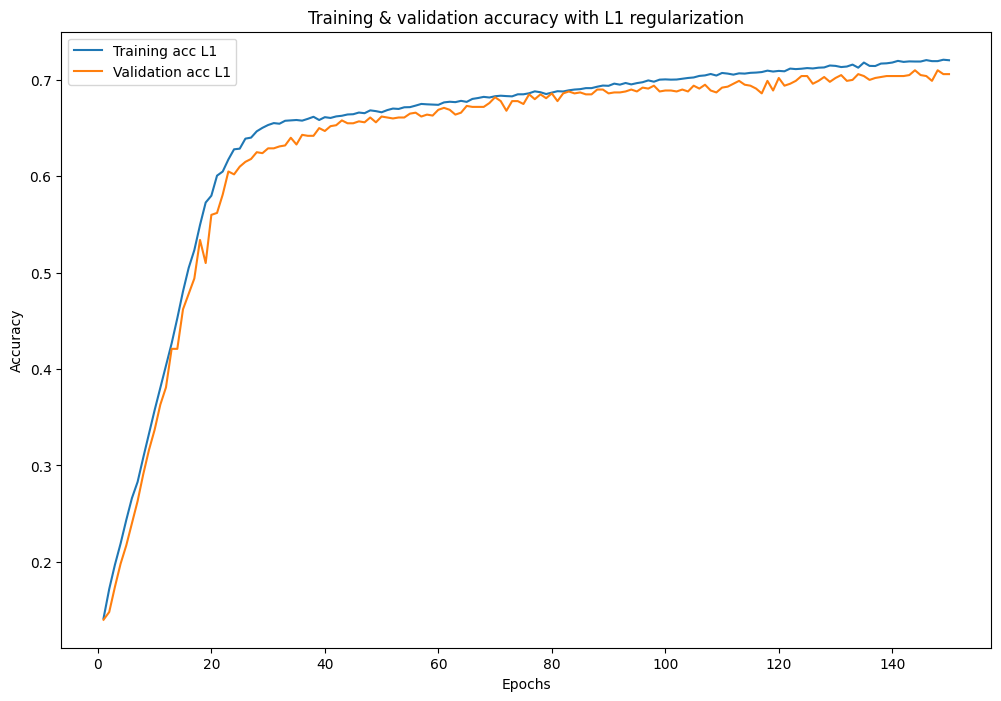

In [26]:
fig, ax = plt.subplots(figsize=(12, 8))

L1_model_dict = L1_model_val.history

acc_values = L1_model_dict['acc'] 
val_acc_values = L1_model_dict['val_acc']

epochs = range(1, len(acc_values) + 1)
ax.plot(epochs, acc_values, label='Training acc L1')
ax.plot(epochs, val_acc_values, label='Validation acc L1')
ax.set_title('Training & validation accuracy with L1 regularization')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend();

Notice how the training and validation accuracy don't diverge as much as before. Unfortunately, the validation accuracy isn't still that good. Next, experiment with dropout regularization to see if it offers any advantages. 


## Dropout Regularization 

It's time to try another technique: applying dropout to layers. As discussed in the earlier lesson, this involves setting a certain proportion of units in each layer to zero. In the following cell: 

- Apply a dropout rate of 30% to the input layer 
- Add a first hidden layer with 50 units and `'relu'` activation 
- Apply a dropout rate of 30% to the first hidden layer 
- Add a second hidden layer with 25 units and `'relu'` activation 
- Apply a dropout rate of 30% to the second hidden layer 


In [28]:
# ⏰ This cell may take about a minute to run
random.seed(123)
dropout_model = models.Sequential()

# Implement dropout to the input layer
# NOTE: This is where you define the number of units in the input layer
dropout_model.add(layers.Dropout(0.3, input_shape=(2000,)))

# Add the first hidden layer
dropout_model.add(layers.Dense(50, activation='relu'))

# Implement dropout to the first hidden layer 
dropout_model.add(layers.Dropout(0.3))

# Add the second hidden layer
dropout_model.add(layers.Dense(25, activation='relu'))

# Implement dropout to the second hidden layer 
dropout_model.add(layers.Dropout(0.3))

# Add the output layer
dropout_model.add(layers.Dense(7, activation='softmax'))


# Compile the model
dropout_model.compile(optimizer='SGD', 
                      loss='categorical_crossentropy', 
                      metrics=['acc'])

# Train the model
dropout_model_val = dropout_model.fit(X_train_tokens, 
                                      y_train_lb, 
                                      epochs=150, 
                                      batch_size=256, 
                                      validation_data=(X_val_tokens, y_val_lb))

Epoch 1/150
30/30 [==============================] - 0s 4ms/step - loss: 1.9909 - acc: 0.1371 - val_loss: 1.9572 - val_acc: 0.1480
Epoch 2/150
30/30 [==============================] - 0s 2ms/step - loss: 1.9653 - acc: 0.1620 - val_loss: 1.9467 - val_acc: 0.1610
Epoch 3/150
30/30 [==============================] - 0s 2ms/step - loss: 1.9502 - acc: 0.1687 - val_loss: 1.9401 - val_acc: 0.1730
Epoch 4/150
30/30 [==============================] - 0s 2ms/step - loss: 1.9471 - acc: 0.1685 - val_loss: 1.9352 - val_acc: 0.1850
Epoch 5/150
30/30 [==============================] - 0s 2ms/step - loss: 1.9377 - acc: 0.1845 - val_loss: 1.9300 - val_acc: 0.1940
Epoch 6/150
30/30 [==============================] - 0s 2ms/step - loss: 1.9347 - acc: 0.1815 - val_loss: 1.9253 - val_acc: 0.1980
Epoch 7/150
30/30 [==============================] - 0s 2ms/step - loss: 1.9277 - acc: 0.1963 - val_loss: 1.9205 - val_acc: 0.2020
Epoch 8/150
30/30 [==============================] - 0s 2ms/step - loss: 1.9199 - a

In [29]:
results_train = dropout_model.evaluate(X_train_tokens, y_train_lb)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_test = dropout_model.evaluate(X_test_tokens, y_test_lb)
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}') 

235/235 [==============================] - 0s 394us/step - loss: 0.5456 - acc: 0.8089
Training Loss: 0.546 
Training Accuracy: 0.809
----------
47/47 [==============================] - 0s 538us/step - loss: 0.6214 - acc: 0.7767
Test Loss: 0.621 
Test Accuracy: 0.777


You can see here that the validation performance has improved again, and the training and test accuracy are very close!  

## Bigger Data? 

Finally, let's examine if we can improve the model's performance just by adding more data. We've quadrapled the sample dataset from 10,000 to 40,000 observations, and all you need to do is run the code! 

In [30]:
df_bigger_sample = df.sample(40000, random_state=123)

X = df['Consumer complaint narrative']
y = df['Product']

# Train-test split
X_train_bigger, X_test_bigger, y_train_bigger, y_test_bigger = train_test_split(X, 
                                                                                y, 
                                                                                test_size=6000, 
                                                                                random_state=42)

# Validation set
X_train_final_bigger, X_val_bigger, y_train_final_bigger, y_val_bigger = train_test_split(X_train_bigger, 
                                                                                          y_train_bigger, 
                                                                                          test_size=4000, 
                                                                                          random_state=42)


# One-hot encoding of the complaints
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(X_train_final_bigger)

X_train_tokens_bigger = tokenizer.texts_to_matrix(X_train_final_bigger, mode='binary')
X_val_tokens_bigger = tokenizer.texts_to_matrix(X_val_bigger, mode='binary')
X_test_tokens_bigger = tokenizer.texts_to_matrix(X_test_bigger, mode='binary')

# One-hot encoding of products
lb = LabelBinarizer()
lb.fit(y_train_final_bigger)

y_train_lb_bigger = to_categorical(lb.transform(y_train_final_bigger))[:, :, 1]
y_val_lb_bigger = to_categorical(lb.transform(y_val_bigger))[:, :, 1]
y_test_lb_bigger = to_categorical(lb.transform(y_test_bigger))[:, :, 1]

In [31]:
# ⏰ This cell may take several minutes to run
random.seed(123)
bigger_data_model = models.Sequential()
bigger_data_model.add(layers.Dense(50, activation='relu', input_shape=(2000,)))
bigger_data_model.add(layers.Dense(25, activation='relu'))
bigger_data_model.add(layers.Dense(7, activation='softmax'))

bigger_data_model.compile(optimizer='SGD', 
                          loss='categorical_crossentropy', 
                          metrics=['acc'])

bigger_data_model_val = bigger_data_model.fit(X_train_tokens_bigger,  
                                              y_train_lb_bigger,  
                                              epochs=150,  
                                              batch_size=256,  
                                              validation_data=(X_val_tokens_bigger, y_val_lb_bigger))

Epoch 1/150
196/196 [==============================] - 0s 1ms/step - loss: 1.9058 - acc: 0.2352 - val_loss: 1.8353 - val_acc: 0.3178
Epoch 2/150
196/196 [==============================] - 0s 1ms/step - loss: 1.7066 - acc: 0.3808 - val_loss: 1.5606 - val_acc: 0.4588
Epoch 3/150
196/196 [==============================] - 0s 1ms/step - loss: 1.3752 - acc: 0.5447 - val_loss: 1.2260 - val_acc: 0.5978
Epoch 4/150
196/196 [==============================] - 0s 1ms/step - loss: 1.0941 - acc: 0.6481 - val_loss: 1.0059 - val_acc: 0.6625
Epoch 5/150
196/196 [==============================] - 0s 1ms/step - loss: 0.9204 - acc: 0.6903 - val_loss: 0.8773 - val_acc: 0.6895
Epoch 6/150
196/196 [==============================] - 0s 1ms/step - loss: 0.8165 - acc: 0.7146 - val_loss: 0.7998 - val_acc: 0.7088
Epoch 7/150
196/196 [==============================] - 0s 1ms/step - loss: 0.7507 - acc: 0.7306 - val_loss: 0.7468 - val_acc: 0.7225
Epoch 8/150
196/196 [==============================] - 0s 1ms/step - 

In [32]:
results_train = bigger_data_model.evaluate(X_train_tokens_bigger, y_train_lb_bigger)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_test = bigger_data_model.evaluate(X_val_tokens_bigger, y_val_lb_bigger)
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')

1563/1563 [==============================] - 0s 304us/step - loss: 0.2781 - acc: 0.9061
Training Loss: 0.278 
Training Accuracy: 0.906
----------
125/125 [==============================] - 0s 357us/step - loss: 0.5972 - acc: 0.8065
Test Loss: 0.597 
Test Accuracy: 0.807


With the same amount of epochs and no regularization technique, you were able to get both better test accuracy and loss. You can still consider early stopping, L1, L2 and dropout here. It's clear that having more data has a strong impact on model performance! 


## Additional Resources

* https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Consumer_complaints.ipynb
* https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
* https://catalog.data.gov/dataset/consumer-complaint-database 


## Summary  

In this lesson, you built deep learning models using a validation set and used several techniques such as L2 and L1 regularization, dropout regularization, and early stopping to improve the accuracy of your models. 